In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.hub import load_state_dict_from_url

import os,glob
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

from RES_VAE import VAE as VAE
from vgg19 import VGG19

import preprocess as prep

/Users/cw/Desktop/2023 Research/cnn-vae/test/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ModuleNotFoundError: No module named 'preprocess'

In [3]:
batch_size = 16
image_size = 64 #QH edited from 64 to 128
lr = 1e-4
nepoch = 100
start_epoch = 0
#dataset_root = "/media/luke/Quick Storage/Data"
#dataset_root = "/scratch/gpfs/qh8777/qhhome/celebA"
save_dir = "/Users/cw/Desktop/2023 Research/EXPERIMENTS/test_shifted_checkpoint"
model_name = "test_run"
load_checkpoint  = True

In [4]:
use_cuda = torch.cuda.is_available()
GPU_indx  = 1
device = torch.device(GPU_indx if use_cuda else "cpu")
device

device(type='cpu')

In [5]:
#only if not using GPU
device = torch.device("cpu")
device

device(type='cpu')

In [7]:
dataset_root = '/Users/cw/Desktop/2023 Research/EXPERIMENTS/new_transform_shifted/'
transform = transforms.Compose([# transforms.Resize(image_size),
                                # transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

def split_dataset():

    train_im_ids = []
    test_im_ids = []    

    # Get all .png files in the folder
    png_files = [file for file in os.listdir(dataset_root) if file.endswith('.png')]

    # Shuffle the list of files randomly
    random.shuffle(png_files)

    # Calculate the split index for train/test
    split_index = int(0.8 * len(png_files))  #80%training

    # Assign 80% as train_im_ids and 20% as test_im_ids
    train_im_ids = png_files[:split_index]
    test_im_ids = png_files[split_index:]

    return train_im_ids, test_im_ids

# training code
train_ids, test_ids = split_dataset()
print('num train_images:', len(train_ids))
print('num test_images:', len(test_ids))

# heavy cpu load, light memory load
class ImageDiskLoader(torch.utils.data.Dataset):

    def __init__(self, im_ids):
        self.transform = transform
        self.im_ids = im_ids

    def __len__(self):
        return len(self.im_ids)

    def __getitem__(self, idx):
        im_name = self.im_ids[idx]
        im_path = dataset_root + self.im_ids[idx]
        im = Image.open(im_path).convert('RGB')
        #im = crop(im, 30, 0, 178, 178)
        data = self.transform(im)

        return data, im_name
    
data_train = ImageDiskLoader(train_ids)
data_test = ImageDiskLoader(test_ids)

kwargs = {'num_workers': 1,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, **kwargs)

num train_images: 5600
num test_images: 1400


In [41]:


trainloader, testloader = get_data_CelebA(transform, batch_size, download=False, root=dataset_root)

NameError: name 'get_data_CelebA' is not defined

In [8]:
#get a test image batch from the testloader to visualise the reconstruction quality
dataiter = iter(test_loader)
test_images, image_ids = next(dataiter)

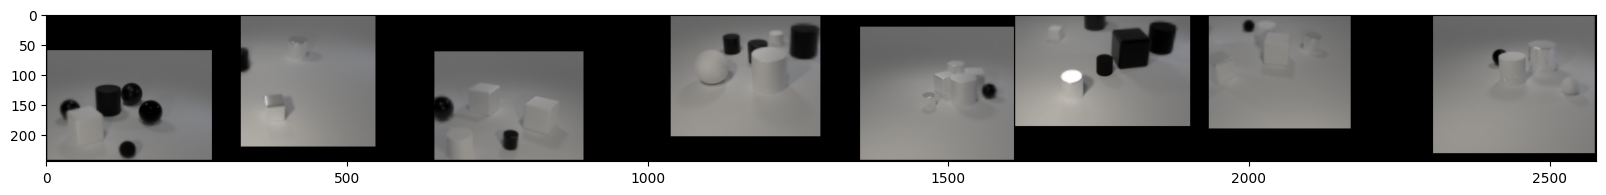

In [9]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [10]:
# Create the feature loss module
feature_extractor = VGG19().to(device)

In [11]:
#Create VAE network
vae_net = VAE(channel_in=3, ch=64, latent_channels=256).to(device)
# setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
#Loss function
loss_log = []

In [12]:
#Create the save directory if it does note exist
if not os.path.isdir(save_dir + "/Models"):
    os.makedirs(save_dir + "/Models")
if not os.path.isdir(save_dir + "/Results"):
    os.makedirs(save_dir + "/Results")

if load_checkpoint:
    checkpoint = torch.load(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt", map_location = "cpu")
    print("Checkpoint loaded")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint["epoch"]
    #loss_log = checkpoint["loss_log"]
else:
    #If checkpoint does exist raise an error to prevent accidental overwriting
    if os.path.isfile(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt"):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded


In [12]:
#plot loss function (dont run)
'''
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(16,8))
for i in range(len(loss_log)):
    #print(train_losses[i][0], train_losses[i][1])
    ax[0].plot(i, loss_log[i], 'bo')
ax[0].set(title = 'training')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('training loss')


plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\n#fig = plt.figure()\nfig, ax = plt.subplots(1,2, figsize=(16,8))\nfor i in range(len(loss_log)):\n    #print(train_losses[i][0], train_losses[i][1])\n    ax[0].plot(i, loss_log[i], 'bo')\nax[0].set(title = 'training')\nax[0].set_xlabel('iteration')\nax[0].set_ylabel('training loss')\n\n\nplt.show()\n"

In [13]:
dataiter = iter(train_loader)
images, image_ids = next(dataiter)
len(dataiter)

350

In [14]:
recon_img, mu, logvar = vae_net(images)
recon_img

tensor([[[[-6.3964e-01, -7.6110e-01, -8.5460e-01,  ..., -8.2219e-01,
           -7.5482e-01, -5.7193e-01],
          [-7.6974e-01, -7.8673e-01, -8.5212e-01,  ..., -8.2977e-01,
           -8.1272e-01, -7.4856e-01],
          [-8.2111e-01, -8.2100e-01, -8.5297e-01,  ..., -8.1634e-01,
           -8.0447e-01, -7.6984e-01],
          ...,
          [-8.5044e-01, -8.5255e-01, -8.4718e-01,  ...,  2.3354e-04,
           -2.2776e-02,  4.1839e-02],
          [-8.1040e-01, -8.4123e-01, -8.6417e-01,  ...,  8.0602e-02,
            5.5783e-02,  4.7765e-02],
          [-7.4377e-01, -7.9120e-01, -8.1598e-01,  ..., -8.1029e-03,
           -3.2876e-02, -5.2115e-02]],

         [[-6.8784e-01, -8.0179e-01, -8.5918e-01,  ..., -8.5049e-01,
           -8.1642e-01, -7.2487e-01],
          [-8.5155e-01, -7.7783e-01, -8.3046e-01,  ..., -8.1387e-01,
           -7.7502e-01, -7.7850e-01],
          [-8.9167e-01, -7.8742e-01, -8.3945e-01,  ..., -8.2806e-01,
           -7.9794e-01, -8.4221e-01],
          ...,
     

In [22]:
len(logvar[0]) #mu/logvar dimension: 64x512x5x5
def sample(mu, logvar):
    std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
    eps = torch.randn_like(std)  # random ~ N(0, 1)
    return eps.mul(std).add_(mu)
z = sample(mu,logvar)
sample_img_all = vae_net.decoder(z)
zs = z[0:1]
sample_img = vae_net.decoder(zs)
z.shape,zs.shape

(torch.Size([16, 256, 12, 17]), torch.Size([1, 256, 12, 17]))

In [23]:
#instead of above that finds the latents corresponding to a training image, I randomly generate the latents
size = torch.Size([1, 4, 5, 5])
z_random = torch.randn(size)
z_random.shape

torch.Size([1, 4, 5, 5])

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import crop

def plot_latent(z_temp):

    #im = torch.squeeze(model.decode(z_temp).cpu())
    im = vae_net.decoder(z_temp)
    img = im.detach().numpy().squeeze()
    img_t = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
    img_t[:,:,0] = img[0,:,:].squeeze()
    img_t[:,:,1] = img[1,:,:].squeeze()
    img_t[:,:,2] = img[2,:,:].squeeze()
    img_t =  (img_t - img_t.min()) / (img_t.max() - img_t.min()) #normalize between 0 and 1
    plt.imshow(img_t)

torch.Size([16, 256, 12, 17])


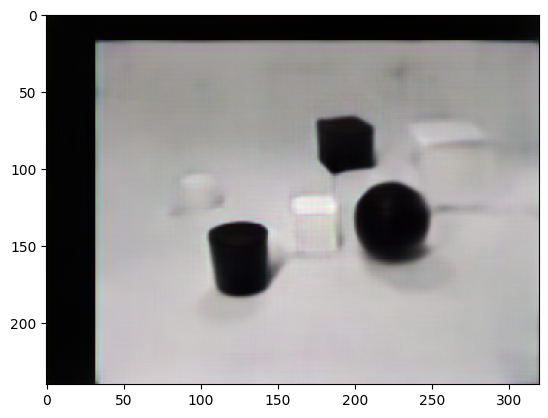

In [25]:
print(z.size())
plot_latent(z[0:1])
#plot_latent(z_random) 

In [26]:
print(image_ids)

('shifted_CLEVR_new_005100.png', 'shifted_CLEVR_new_002192.png', 'shifted_CLEVR_new_001571.png', 'shifted_CLEVR_new_000035.png', 'shifted_CLEVR_new_000081.png', 'shifted_CLEVR_new_005363.png', 'shifted_CLEVR_new_002865.png', 'shifted_CLEVR_new_004555.png', 'shifted_CLEVR_new_005023.png', 'shifted_CLEVR_new_004957.png', 'shifted_CLEVR_new_006745.png', 'shifted_CLEVR_new_003053.png', 'shifted_CLEVR_new_005464.png', 'shifted_CLEVR_new_003041.png', 'shifted_CLEVR_new_005913.png', 'shifted_CLEVR_new_004773.png')


In [27]:
import cv2
import json
def draw_cross(im, fixations, color=(0, 255, 0), thickness=2, size=3):
    """
    Draw a cross at the location of each fixation.

    Parameters:
    - im: The image to draw on.
    - fixations: The list of fixation points.
    - color: The color of the cross (default is green).
    - thickness: The thickness of the lines (default is 2).
    - size: The size of the cross (default is 20).
    """
    for (x, y) in fixations:
        # Draw a line from top to bottom
        cv2.line(im, (x, y-size), (x, y+size), color, thickness)
        # Draw a line from left to right
        cv2.line(im, (x-size, y), (x+size, y), color, thickness)

    return im 

with open('new_transform_retina.json', 'r') as f:
    fixation_data = json.load(f)

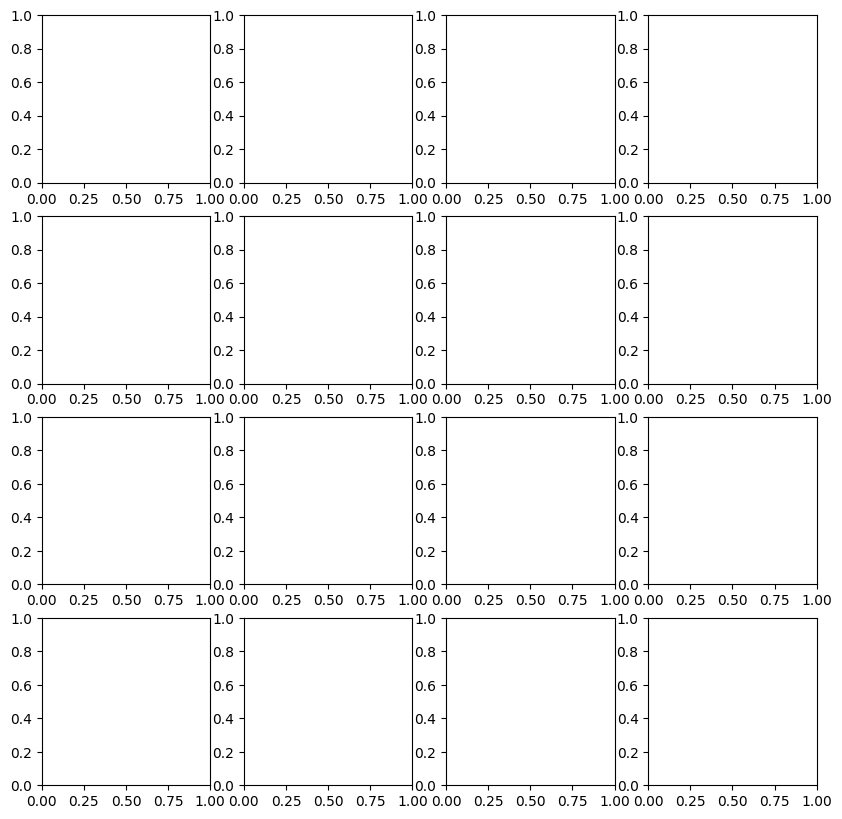

In [28]:
#plot original image
n_images = 1
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (10,10))

for i in range(n_images):
    '''
    image_id = image_ids[i]

    fixation = fixation_data[image_id]
    x_fixation = fixation['xc']
    y_fixation = fixation['yc'] 
    '''
    x_fixation = 160
    y_fixation = 120

    img = images[i].numpy().squeeze()
    img_o = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
    img_o[:,:,0] = img[0,:,:].squeeze()
    img_o[:,:,1] = img[1,:,:].squeeze()
    img_o[:,:,2] = img[2,:,:].squeeze()
    img_o =  (img_o - img_o.min()) / (img_o.max() - img_o.min()) #normalize between 0 and 1
    img_o = (img_t * 255).astype(np.uint8) # Scale back to 0-255
    img_o = draw_cross(img_o, [(x_fixation, y_fixation)])

    cv2.imwrite(f'reconstructed_{i}.png', img_o)

#plt.imshow(img_o)
#plt.savefig("original.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(240, 320, 3)


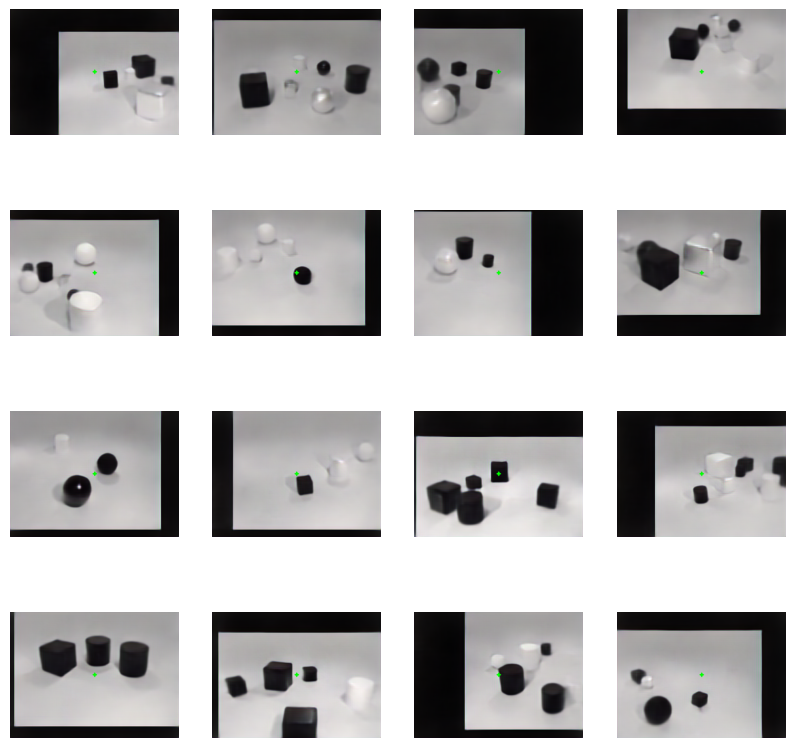

In [66]:
#plot reconstructed image
n_images = 16
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (10,10))

for i in range(n_images):

    x_fixation = 160
    y_fixation = 120

    img = recon_img[i].detach().numpy().squeeze()
    img_t = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
    img_t[:,:,0] = img[0,:,:].squeeze()
    img_t[:,:,1] = img[1,:,:].squeeze()
    img_t[:,:,2] = img[2,:,:].squeeze()
    img_t =  (img_t - img_t.min()) / (img_t.max() - img_t.min()) #normalize between 0 and 1
    img_t = draw_cross(img_t, [(x_fixation, y_fixation)])

    # Define the current row and column
    row = i // 4
    col = i % 4

    axes[row, col].imshow(img_t)
    axes[row, col].axis('off')

plt.imshow(img_t)
plt.savefig("reconstructed.png")
print(img_t.shape)

(240, 320)


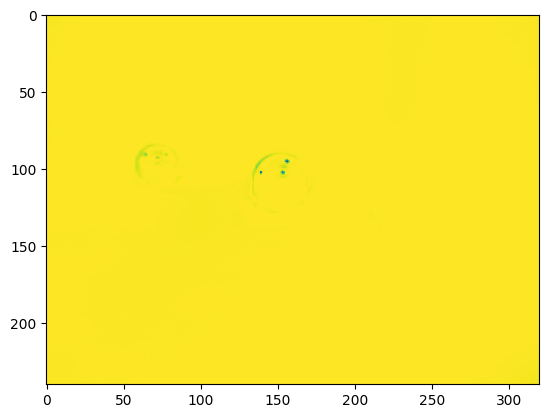

In [112]:
#diff image 

diff_image = (img_o - img_t)**2
diff_image = 0.2989 * diff_image[:,:,0] + 0.5870 * diff_image[:,:,1] + 0.1140 * diff_image[:,:,2]

diff_image_normalized = (diff_image - diff_image.min()) / (diff_image.max())
diff_image_inverted = 1.0 - diff_image_normalized
plt.imshow(diff_image_inverted)
print(diff_image_inverted.shape)


(240, 320)
(76800,)
(76800,)


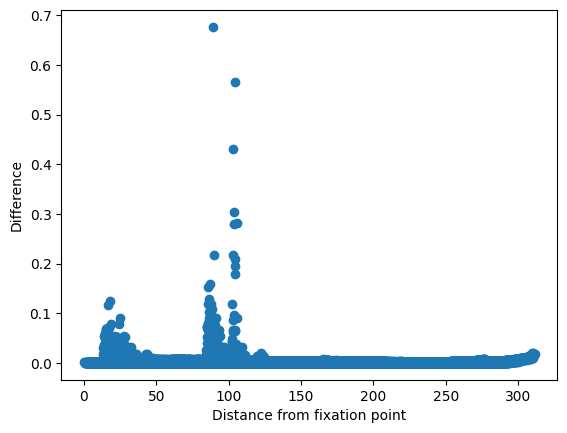

In [113]:
import numpy as np
import matplotlib.pyplot as plt

x_fixation = 53
y_fixation = 77

# Create coordinate arrays
Y, X = np.ogrid[:240, :320]

# Compute the distance from the fixation point for each pixel
distance = np.sqrt((X - x_fixation)**2 + (Y - y_fixation)**2)
print(distance.shape)

# Flatten both the distance and error arrays for plotting
distance_flat = distance.flatten()
error_flat = diff_image.flatten()

print(distance_flat.shape)
print(error_flat.shape)

# Plot error against distance
plt.scatter(distance_flat, error_flat)
plt.xlabel('Distance from fixation point')
plt.ylabel('Difference')
plt.show()